# Appendix: Text classification

In this section, we train a convolutional network on text embeddings. The dataset we use consist of Spanish given names[^1]. Our task is to classify a name into its gender label provided in the dataset. Note that the following is purely an academic exercise. The resulting model could perpetuate bias if used in real-world applications.

[^1]: https://github.com/jvalhondo/spanish-names-surnames

In [1]:
!curl "https://raw.githubusercontent.com/jvalhondo/spanish-names-surnames/master/male_names.csv" --output ./data/spanish-male-names.csv 
!curl "https://raw.githubusercontent.com/jvalhondo/spanish-names-surnames/master/female_names.csv" --output ./data/spanish-female-names.csv 


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  479k  100  479k    0     0  1035k      0 --:--:-- --:--:-- --:--:-- 1036k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  482k  100  482k    0     0  1137k      0 --:--:-- --:--:-- --:--:-- 1139k


In [2]:
from chapter import *

In [3]:
dfs = []
files = ["spanish-male-names.csv", "spanish-female-names.csv"]
for i, g in enumerate(["M", "F"]):
    df_ = pd.read_csv(DATASET_DIR / files[i])
    df_ = df_[["name"]].dropna(axis=0, how="any")
    df_["name"] = df_.name.map(lambda s: s.replace(" ", "_").lower())
    df_["gender"] = g
    dfs.append(df_)

df = pd.concat(dfs, axis=0).drop_duplicates().reset_index(drop=True)
df

,name,gender
0,antonio,M
1,jose,M
2,manuel,M
3,francisco,M
4,juan,M
...,...,...
49334,zhihui,F
49335,zoila_esther,F
49336,zsanett,F
49337,zuleja,F


In [4]:
df.gender.value_counts()

gender
F    24755
M    24584
Name: count, dtype: int64

The histogram of name lengths is multimodal due to having multiple subnames
separated by space.

Max name length: 27


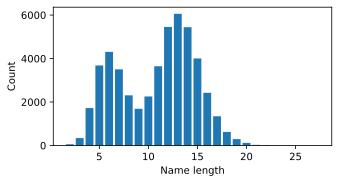

In [5]:
from collections import Counter

name_length = Counter([len(n) for n in df.name])
lengths = sorted(name_length.keys())

plt.figure(figsize=(5, 2.5))
plt.bar(lengths, [name_length[k] for k in lengths])
plt.xlabel("Name length")
plt.ylabel("Count")
print("Max name length:", max(lengths))

In [6]:
len(df[df.name.apply(len) < 23]) / len(df)

0.9997365167514543

## Data loaders

We pad names with one `.` on the left to indicate the start of a name, and enough `.` on the right so that input names have the same length. Long names are truncated to a max length. This is typical for language models due to architectural constraints. In any case, a sufficiently large fixed number of initial characters of a name should be enough to determine the label.

In [7]:
MAX_LEN = 23
CHARS = ["."] + sorted(list(set([c for n in df.name for c in n])))
VOCAB_SIZE = len(CHARS)

print("token count:", VOCAB_SIZE)
print("".join(CHARS))

token count: 31
.'_abcdefghijklmnopqrstuvwxyzçñ


From above, almost all of the names are within 23 characters long. The above padding rule means that inputs to the network have length `MAX_LEN + 1`. 

In [8]:
from torch.utils.data import Dataset, DataLoader, random_split

class NamesDataset(Dataset):
    def __init__(self, names: list[str], label: list[int]):
        self.char_to_int = {c: i for i, c in enumerate(CHARS)}
        self.label_map = {"F": 1, "M": 0}
        self.names = names
        self.label = label

    def encode(self, name: str):
        return [self.char_to_int[char] for char in self.preprocess(name)]

    def decode(self, x: torch.Tensor):
        int_to_char = {i: c for c, i in self.char_to_int.items()}
        return "".join(int_to_char[i.item()] for i in x)
        
    def __len__(self):
        return len(self.names)

    def __getitem__(self, i):
        y = torch.tensor(self.label_map[self.label[i]])
        x = torch.tensor(self.encode(self.names[i]))
        return x, y

    @staticmethod
    def preprocess(name: str) -> str:
        """Prepend with dot and pad. Final length: MAX_LEN + 1."""
        out = [c for c in name if c in CHARS]
        return "." + "".join(out)[:min(len(out), MAX_LEN)] + "." * (MAX_LEN - len(out))


g = torch.Generator().manual_seed(RANDOM_SEED)
names = df.name.tolist()
label = df.gender.tolist()

ds = NamesDataset(names, label)
ds_train, ds_valid = random_split(ds, [0.8, 0.2], generator=g)
dl_train = DataLoader(ds_train, batch_size=32, shuffle=True)
dl_valid = DataLoader(ds_valid, batch_size=32, shuffle=False)

Sample instance:

In [9]:
x, y = next(iter(dl_train))
x[:5, :15], y[:5]

(tensor([[ 0, 21,  3, 15, 23,  7, 14,  2, 20,  3,  8,  3,  7, 14,  0],
         [ 0, 15, 11, 10,  3,  7, 14,  3,  2, 21, 11, 15, 17, 16,  3],
         [ 0, 12, 10, 23, 14, 11,  3, 16,  3,  0,  0,  0,  0,  0,  0],
         [ 0, 27, 17, 16,  3, 22,  3, 16,  0,  0,  0,  0,  0,  0,  0],
         [ 0,  9, 11, 23, 14, 11,  3,  0,  0,  0,  0,  0,  0,  0,  0]]),
 tensor([0, 1, 1, 0, 1]))

Decoding:

In [10]:
for i in range(5):
    name = ds.decode(x[i])
    print(name, {1: "F", 0: "M"}[y[i].item()])

.samuel_rafael.......... M
.mihaela_simona......... F
.jhuliana............... F
.yonatan................ M
.giulia................. F


## Model

The convolution kernel runs across a context of characters with stride 1. Subnames are short, so a context size of 3 or 4 should be good. Note that we use **embeddings** as input to the convolutional layers of size `d_emb`. Hence, the kernel is applied to sequential blocks of embeddings that have size `n × d_emb` where `n` is the context size, and a stride `d_emb` which is equivalent to skipping one character ({numref}`03-text-cnn`).

```{figure} ../../../img/nn/03-text-cnn.png
---
width: 740px
name: 03-text-cnn
align: center
---

Model architecture to classify text using convolutions. The kernel slides over embeddings instead of pixels. [Source](https://lena-voita.github.io/nlp_course/models/convolutional.html#text_classification)
```

```{figure} ../../../img/nn/03-maxpool-over-time.png
---
width: 500px
name: 03-maxpool-over-time
align: center
---

Zooming in on a portion of the model architecture in {numref}`03-text-cnn`. Max pooling over time reduces the feature map to a vector whose entries correspond to the largest value in each output channel over the entire sequence. [Source](https://lena-voita.github.io/nlp_course/models/convolutional.html#text_classification)
```

The model determines the gender label of a name by looking at the presence of certain *n*-grams in a name (i.e. one detector for each channel), regardless of its position in the name. This is done using **max pool over time** ({numref}`03-maxpool-over-time`) which converts the `[conv_width, T]` tensor to `[conv_width, 1]` containing the max activations. Here `conv_width` is the number of *n*-gram detectors where *n* is the context size. Finally, the resulting vector is passed to an MLP. 

Implementing the model:

In [11]:
import torchinfo

class TextCNN(nn.Module):
    def __init__(self, 
                 d_emb=10,
                 context=3,
                 fc_width=256,
                 conv_width=64,
                 vocab_size=VOCAB_SIZE):

        super().__init__()
        T = (MAX_LEN + 1) - context + 1  # no. conv steps
        
        self.C = nn.Embedding(vocab_size, d_emb)
        self.conv1 = nn.Conv1d(1, conv_width, context*d_emb, d_emb)
        self.relu1 = nn.ReLU()
        self.pool_over_time = nn.MaxPool1d(T)
        
        self.fc = nn.Sequential(
            nn.Linear(conv_width, fc_width),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(fc_width, 2)
        )

    def forward(self, x):
        B = x.shape[0]
        x = self.C(x)
        x = x.reshape(B, 1, -1)
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.pool_over_time(x)
        return self.fc(x.reshape(B, -1))


torchinfo.summary(TextCNN(), input_size=(1, MAX_LEN + 1), dtypes=[torch.int64])

Layer (type:depth-idx)                   Output Shape              Param #
TextCNN                                  [1, 2]                    --
├─Embedding: 1-1                         [1, 24, 10]               310
├─Conv1d: 1-2                            [1, 64, 22]               1,984
├─ReLU: 1-3                              [1, 64, 22]               --
├─MaxPool1d: 1-4                         [1, 64, 1]                --
├─Sequential: 1-5                        [1, 2]                    --
│    └─Linear: 2-1                       [1, 256]                  16,640
│    └─ReLU: 2-2                         [1, 256]                  --
│    └─Dropout: 2-3                      [1, 256]                  --
│    └─Linear: 2-4                       [1, 2]                    514
Total params: 19,448
Trainable params: 19,448
Non-trainable params: 0
Total mult-adds (M): 0.06
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 0.08
Estimated Total Size (MB): 0.09

## Training

In [12]:
model = TextCNN(conv_width=128, context=4, fc_width=256)
optim = torch.optim.Adam(model.parameters(), lr=0.001)
trainer = Trainer(model, optim, loss_fn=F.cross_entropy)
trainer.run(epochs=5, train_loader=dl_train, valid_loader=dl_valid)

  0%|          | 0/5 [00:00<?, ?it/s]

[Epoch: 1/5]    loss: 0.2036  acc: 0.9155    val_loss: 0.2086  val_acc: 0.9046
[Epoch: 2/5]    loss: 0.1905  acc: 0.9124    val_loss: 0.1962  val_acc: 0.9123
[Epoch: 3/5]    loss: 0.1804  acc: 0.9206    val_loss: 0.1854  val_acc: 0.9170
[Epoch: 4/5]    loss: 0.1751  acc: 0.9196    val_loss: 0.1865  val_acc: 0.9179
[Epoch: 5/5]    loss: 0.1739  acc: 0.9237    val_loss: 0.1655  val_acc: 0.9251


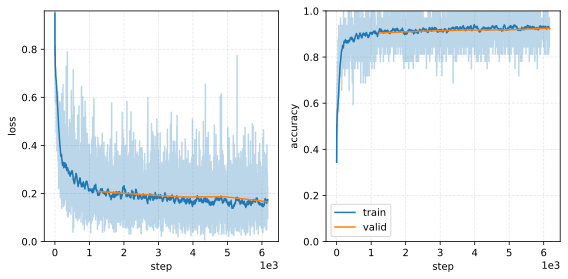

In [13]:
plot_training_history(trainer)

## Inference

In [14]:
data = [ 
    "maria",
    "clara",
    "maria_clara",
    "tuco",
    "salamanca",
    "tuco_salamanca",
]

# Model prediction
x = torch.tensor([ds.encode(n) for n in data])
probs = F.softmax(trainer.predict(x), dim=1)[:, 1].cpu()  # p(F|name)

In [15]:
print("name                         p(F|name)")
print("--------------------------------------")
for i, name in enumerate(data):
    print(f"{name + ' ' * (MAX_LEN - len(name))} \t{probs[i]:.3f}")

name                         p(F|name)
--------------------------------------
maria                   	0.983
clara                   	0.963
maria_clara             	1.000
tuco                    	0.268
salamanca               	0.929
tuco_salamanca          	0.292


**Remark.** The model seems to compose inputs well since the model is able to perform convolution over spaces (`_`).

---
■